### Hipparcos HR - diagram

In this notebook, we will import the Hipparcos catalog and calculate the absolute stellar magnitudes required to plot the famous HR diagram. 

### 1. Importing and preparing data 

First, we will import data from the Hipparcos catalog into a DataFrame and prepare numerical columns. By selecting only the single stars from the dataset, we can recognize various distinct features of the HR diagram and observe how the temperature and the brightness of the stars change throughout their lives. 

In [1]:
#importing Python libraries
import numpy as np
import pandas as pd

file = '../data/hip_sp.csv'

#defining column names
new_column_names = ['Hip_No', 'Alpha', 'Delta','Vmag','Plx', 'e_Plx', 'B-V','e_B-V', 'ccdm_h','Spectral_type']

#importing data
hip_all_stars = pd.read_csv(file, header = None, sep =',',
                usecols = [1,2,3,4,5,6,7,8,9,10],  
                names = new_column_names,
                low_memory = False)

#changing column types
col_list = ['Vmag', 'Plx', 'e_Plx', 'B-V', 'e_B-V']
for  col in col_list:
   hip_all_stars[col] = pd.to_numeric(hip_all_stars[col],  errors = 'coerce') 

#selecting only single stars with no ccdm_h flag
df = hip_all_stars.loc[hip_all_stars['ccdm_h']==' ']

#dropping ccdm_h column
hip = df.drop(['ccdm_h'], axis = 1) 

#displaying DataFrame
hip.head(5)

,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,Spectral_type
0,1,00 00 00.22,+01 05 20.4,9.10,3.54,1.39,0.482,0.025,F5
1,2,00 00 00.91,-19 29 55.8,9.27,21.90,3.10,0.999,0.002,K3V
3,4,00 00 02.01,-51 53 36.8,8.06,7.75,0.97,0.370,0.009,F0V
4,5,00 00 02.39,-40 35 28.4,8.55,2.87,1.11,0.902,0.013,G8III
5,6,00 00 04.35,+03 56 47.4,12.31,18.80,4.99,1.336,0.020,M0V:


### 2.  Calculating absolute stellar magnitudes

The absolute stellar magnitude (Mv) shows the star's real brightness and it can be calculated using the apparent magnitude (Vmag) and the trigonometric parallax (Plx) from the Hipparcos catalog. 

The apparent magnitude (Vmag) shows how bright is an object observed from Earth. The Vmag values are determined by the object's real brightness and distance from Earth and by the amount of interstellar dust between a star and the observer. On the other hand, the absolute magnitude is equal to the star's apparent magnitude if an object is placed at a distance of 10 parsecs from Earth. Therefore using the absolute magnitude we can compare real stellar luminosities of different stars. 

In addition, the trigonometric parallax (Plx) is a measure of the stellar distance using a simple relation that: $$Distance(in\ parsecs) = 1/ Plx (in\ arcseconds)$$.  The Plx values are usually small, positive numbers, but they can also appear as large or negative numbers due to errors in measurements or factors such as the crowded regions of the sky. Hence we will first clean our DataFrame from the stars with the negative parallaxes and negative distances. We will also exclude those stars whose errors in the measured parallaxes are larger than the actual parallaxes. 

In [2]:
#number of stars with no measured parallaxes
no_plx = hip['Plx'].isnull().sum()
print('Number of stars without measured parallaxes:{}'.format(no_plx))

#number of stars with negative parallaxes
negative_plx= sum([plx<0 for plx in hip['Plx'].values])
print('Number of stars with negative parallaxes:{}'.format(negative_plx) )

#selecting stars with positive Plx and with the relative errors in Plx < 0.80
hip_stars = hip.loc[(hip['Plx']>0) & (hip['e_Plx']/hip['Plx'].abs()<0.80)].copy()

#DataFrame with positive parallaxes
print(hip_stars.shape)

Number of stars without measured parallaxes:61
Number of stars with negative parallaxes:3390
(85480, 9)


In [3]:
#creating a new column with the absolute magnitude
%timeit -r2 -n10 hip_stars['Mv'] = hip_stars['Vmag'] + 5 - 5*np.log10(1000/hip_stars['Plx'])

#rounding numbers
hip_stars = hip_stars.round({'Mv': 2})

print(hip_stars.shape)
hip_stars.head(5)

2.95 ms ± 417 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
(85480, 10)


,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,Spectral_type,Mv
0,1,00 00 00.22,+01 05 20.4,9.10,3.54,1.39,0.482,0.025,F5,1.85
1,2,00 00 00.91,-19 29 55.8,9.27,21.90,3.10,0.999,0.002,K3V,5.97
3,4,00 00 02.01,-51 53 36.8,8.06,7.75,0.97,0.370,0.009,F0V,2.51
4,5,00 00 02.39,-40 35 28.4,8.55,2.87,1.11,0.902,0.013,G8III,0.84
5,6,00 00 04.35,+03 56 47.4,12.31,18.80,4.99,1.336,0.020,M0V:,8.68


### 3. The HR - diagram 

The Hertzsprung-Russell (HR) diagram presents the change in the stellar luminosity, absolute magnitude (Mv), with the spectral type (temperature) expressed through the B-V color index. The HR diagram is one of the most important tools in astronomy, allowing astronomers to follow and study stars through different stages of stellar evolution. 

We will now plot Hipparcos stars on the HR diagram by filtering the most prominent stellar groups.

In [4]:
#defining function for the plot
def HR_plot(col_x, col_y, x_start, x_end, y_start, y_end, clr):
    x = col_x
    y = col_y
    plt.plot(x, y, marker='.', linestyle='none', markersize=2, color=clr)
    plt.xlim(x_start,x_end)
    plt.ylim(y_start,y_end)
    plt.xlabel('B-V')
    plt.ylabel('Mv')
    plt.title('Hipparcos Hertzsprung-Russell Diagram')

In [5]:
#plotting HR diagram 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#selecting stars with the relative errors in parallax: e_Plx/abs(Plx) < 10 %
hip1 = hip_stars.loc[(hip_stars['e_Plx']/hip_stars['Plx'].abs())<0.10]

hip_plot = hip1.loc[hip1['B-V']< 2]

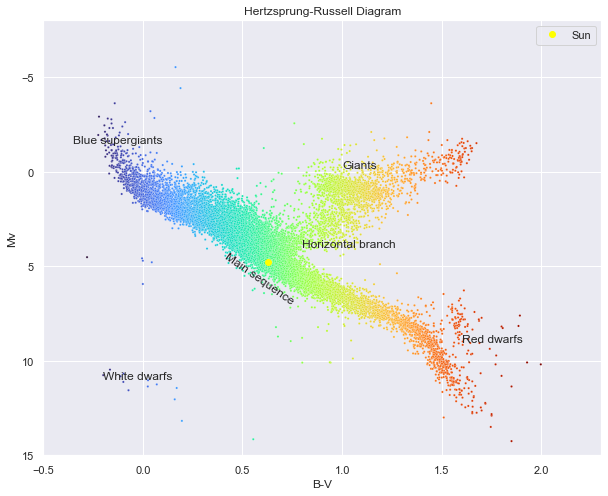

In [6]:
#marking selected stars
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(x ='B-V', y ='Mv', data = hip_plot, hue ='B-V', size ='B-V', sizes = (5,5), palette='turbo')

plt.ylim(15,-8)
plt.xlim(-0.5,2.3)
plt.title('Hertzsprung-Russell Diagram')
plt.annotate('Main sequence', xy=(0.4,7.0), rotation = -35)
plt.annotate('Giants', xy=(1.0,-0.2))
plt.annotate('Horizontal branch ', xy=(0.8,4.0))
plt.annotate('White dwarfs', xy=(-0.2,11.0))
plt.annotate('Red dwarfs', xy=(1.6,9.0))
plt.annotate('Blue supergiants', xy=(-0.35,-1.5))

#Sun's position at 0.63, 4.8
yellow_dot = plt.plot(0.63,4.8, marker='o', color='yellow', linestyle='none')
plt.legend(yellow_dot, ['Sun'])